# Quantum Chemistry (on my own)

In [3]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
class SpinConservation():
    
    def __init__(self,size:int):
        
        self.size=size

    def spin_conservation(self,idxs:List):

        l=len(idxs)

        total_initial_spin=0.
        for idx in idxs[:l//2]:
            
            if idx < self.size:
                total_initial_spin+=1
                
        total_final_spin=0.
        for idx in idxs[l//2:]:
            
            if idx < self.size:
                total_final_spin+=1
        return total_initial_spin==total_final_spin
    
    def local_interaction(self,idxs:List):
        
        condition=idxs[0]==idxs[-1] and idxs[1]==idxs[-2] and idxs[0]+self.size==idxs[1]
        
        return condition

In [3]:
size_a=6
size_b=6
FHHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_a,nparticles_a=2,nparticles_b=2)

u=8.
t=1.
v_ext=np.random.uniform(size=size_a)

# define the local onsite potential
twobody_matrix:Dict={}
for i in range(size_a):
    twobody_matrix[(i,i+size_a,i+size_a,i)]=u
    twobody_matrix[(i, i + size_a, i, i + size_a)] = -u
    twobody_matrix[( i + size_a,i , i + size_a,i)] = -u
    twobody_matrix[(i+size_a, i , i , i+size_a)] = u

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    kinetic_term[(i,(i+1) % size_a)]=t
    kinetic_term[(size_a +i,size_a+(i+1) % size_a)]=t
    adj_matrix[i,(i+1)%size_a]=t
    adj_matrix[(i + 1) % size_a,i]=t
    adj_matrix[i,i]=-2*t
    adj_matrix[i+size_a,i+size_a]=-2*t
    adj_matrix[i+size_a,size_a+ (i + 1) % size_a] = t
    adj_matrix[size_a+(i + 1) % size_a,size_a+ i] = t


print(adj_matrix-adj_matrix.T)
# %%

FHHamiltonian.get_external_potential(external_potential=np.append(v_ext,v_ext))
FHHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
FHHamiltonian.get_hamiltonian()

# print(FHHamiltonian.hamiltonian)
print(FHHamiltonian.hamiltonian)
# print(FHHamiltonian.twobody_operator)
# print(FHHamiltonian.kinetic_operator+FHHamiltonian.twobody_operator-FHHamiltonian.hamiltonian)
egs,psi0=FHHamiltonian.get_spectrum(n_states=1)

print(egs)


# # %% define the fit class

# HFFit = FitHartreeFock(learning_rate=0.1, epochs=200)

# history_hf = HFFit.run(HFE)
# # %%
# psi_hf = HFE.get_psi().detach().numpy()

# print(psi_hf.conjugate().transpose().dot(FHHamiltonian.hamiltonian.dot(psi_hf)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-14.380058584653703
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-6.302228528583765
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-5.555509001265027
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-6.111167415716245
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	1.0
  (221, 221)	-7.

In [4]:
# %% Hartree fock initialization

HFclass = HartreeFock(size=size_a, nspecies=2)

HFclass.get_hamiltonian(twobody_interaction=twobody_matrix, kinetic_term=adj_matrix,external_potential=np.append(v_ext,v_ext))

de, history_herm, ortho_history = HFclass.selfconsistent_computation(eta=1, epochs=50)

de=0.000000000000000: 100%|██████████| 50/50 [00:00<00:00, 587.08it/s]


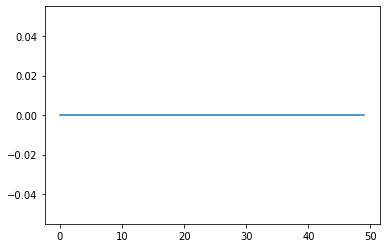

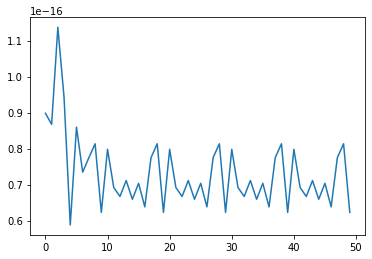

-31.24222954358046


In [5]:
plt.plot(history_herm)
plt.show()

plt.plot(ortho_history)
plt.show()

energy = HFclass.compute_energy()

print(energy)

1.0000000000000002
-0.4022193805566787


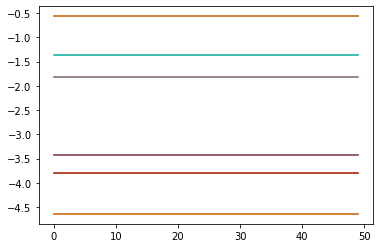

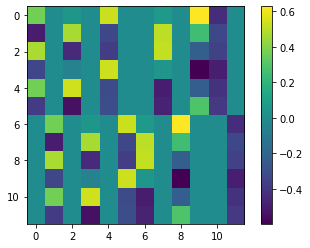

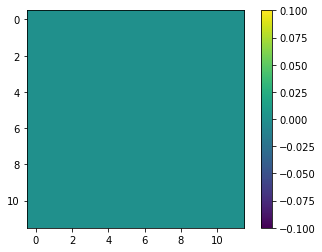

In [6]:
print(np.linalg.norm(HFclass.weights[:, 0]))
print(np.sum(HFclass.weights[0, :].conj() * HFclass.weights[:, 1]))

plt.plot(de)

# plt.semilogy()
# plt.ylim([0,0.001])
plt.show()

plt.imshow(np.real(HFclass.weights))
plt.colorbar()
plt.show()
plt.imshow(np.imag(HFclass.weights))
plt.colorbar()
plt.show()


In [7]:
psi_hf=HFclass.create_hf_psi(FHHamiltonian.basis,nparticles=4)
print(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

-11.274098731386955


In [8]:
# old initialization works better than Hartree Fock
min = 10000
for i, b in enumerate(FHHamiltonian.basis):
    psi = np.zeros(FHHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ FHHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        print(value)
        print(b)
        psi_base = psi

-14.380058584653703
[1 1 0 0 0 0 1 1 0 0 0 0]
-15.678603037631701
[0 1 1 0 0 0 0 1 1 0 0 0]


In [11]:
spinconservation=SpinConservation(size=size_a)
operator_pool:Dict={}

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[spinconservation.spin_conservation],nbody='two')
operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[spinconservation.spin_conservation],nbody='one')
#%%
print('number of operators=',len(list(operator_pool.keys())))

# %%
random=False

model=AdaptVQEFermiHubbard()

model.set_hamiltonian(FHHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf)

model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%


fit=Fit(method='BFGS',tolerance_opt=10**-6,e_ref=egs)

fit.configuration_checkpoint=configuration
fit.init_model(model)

#%%
history,grad_history=fit.run(epochs=50)
# # %%
print(model.operator_action_info)
print(model.energy-egs/egs)

number of operators= 2220


  4%|▍         | 2/50 [00:00<00:03, 14.67it/s]

Optimization Success= True
energy=-12.27224
average gradient=0.000000000016936 

grad tolerance=16.814460597125297 

Optimization Success= True
energy=-13.04577
average gradient=0.000000244680814 

grad tolerance=18.868298057577881 



  8%|▊         | 4/50 [00:00<00:05,  8.10it/s]

Optimization Success= True
energy=-13.98320
average gradient=0.000000070420287 

grad tolerance=15.789101317420663 

Optimization Success= True
energy=-14.70219
average gradient=0.000000120391169 

grad tolerance=17.066132957164125 



 10%|█         | 5/50 [00:00<00:07,  5.93it/s]

Optimization Success= True
energy=-14.88617
average gradient=0.000000437858695 

grad tolerance=14.288509671705567 



 12%|█▏        | 6/50 [00:01<00:10,  4.28it/s]

Optimization Success= True
energy=-15.12136
average gradient=0.000000160442967 

grad tolerance=13.848331471788226 



 14%|█▍        | 7/50 [00:01<00:13,  3.16it/s]

Optimization Success= True
energy=-15.29587
average gradient=0.000000000312393 

grad tolerance=12.898649731263173 



 16%|█▌        | 8/50 [00:02<00:16,  2.53it/s]

Optimization Success= True
energy=-15.50620
average gradient=0.000000003146163 

grad tolerance=12.102551472871701 



 18%|█▊        | 9/50 [00:02<00:20,  1.99it/s]

Optimization Success= True
energy=-15.65360
average gradient=0.000000000006338 

grad tolerance=10.716489965280001 



 20%|██        | 10/50 [00:03<00:25,  1.58it/s]

Optimization Success= True
energy=-15.79960
average gradient=0.000000000000604 

grad tolerance=10.356177508663567 



 22%|██▏       | 11/50 [00:04<00:29,  1.32it/s]

Optimization Success= True
energy=-15.94034
average gradient=0.000000011726581 

grad tolerance=9.831353852679378 



 24%|██▍       | 12/50 [00:06<00:35,  1.09it/s]

Optimization Success= True
energy=-16.07952
average gradient=0.000000000000551 

grad tolerance=9.287064084625609 



 26%|██▌       | 13/50 [00:07<00:37,  1.00s/it]

Optimization Success= True
energy=-16.16074
average gradient=0.000000236923971 

grad tolerance=8.566008954890897 



 28%|██▊       | 14/50 [00:08<00:40,  1.11s/it]

Optimization Success= True
energy=-16.23624
average gradient=0.000000125605667 

grad tolerance=7.995631556413832 



 30%|███       | 15/50 [00:10<00:47,  1.36s/it]

Optimization Success= True
energy=-16.30553
average gradient=0.000000102331396 

grad tolerance=7.188869819241200 



 32%|███▏      | 16/50 [00:12<00:51,  1.51s/it]

Optimization Success= True
energy=-16.37391
average gradient=0.000000058050716 

grad tolerance=6.751970973584561 



 34%|███▍      | 17/50 [00:14<00:54,  1.65s/it]

Optimization Success= True
energy=-16.43461
average gradient=0.000000099572686 

grad tolerance=6.181328435159833 



 36%|███▌      | 18/50 [00:16<00:57,  1.80s/it]

Optimization Success= True
energy=-16.49079
average gradient=0.000000085675572 

grad tolerance=5.486369065123680 



 38%|███▊      | 19/50 [00:19<01:01,  1.97s/it]

Optimization Success= True
energy=-16.54280
average gradient=0.000000265069329 

grad tolerance=4.519954462611948 



 40%|████      | 20/50 [00:21<01:02,  2.08s/it]

Optimization Success= True
energy=-16.59417
average gradient=0.000000218568655 

grad tolerance=3.856179451868352 



 42%|████▏     | 21/50 [00:23<01:00,  2.08s/it]

Optimization Success= True
energy=-16.60424
average gradient=0.000000241786018 

grad tolerance=2.929309763914403 



 44%|████▍     | 22/50 [00:26<01:02,  2.23s/it]

Optimization Success= True
energy=-16.61419
average gradient=0.000000189270883 

grad tolerance=2.708313870740214 



 46%|████▌     | 23/50 [00:28<01:03,  2.36s/it]

Optimization Success= True
energy=-16.62324
average gradient=0.000000196328589 

grad tolerance=2.468240782380874 



 48%|████▊     | 24/50 [00:31<01:05,  2.52s/it]

Optimization Success= True
energy=-16.63236
average gradient=0.000000187071909 

grad tolerance=2.172448185233202 



 50%|█████     | 25/50 [00:34<01:06,  2.65s/it]

Optimization Success= True
energy=-16.63897
average gradient=0.000000276457009 

grad tolerance=1.820119118796669 



 52%|█████▏    | 26/50 [00:37<01:05,  2.73s/it]

Optimization Success= True
energy=-16.64556
average gradient=0.000000298994857 

grad tolerance=1.672691598644891 



 54%|█████▍    | 27/50 [00:40<01:05,  2.85s/it]

Optimization Success= True
energy=-16.64988
average gradient=0.000000105927815 

grad tolerance=1.508205813629106 



 56%|█████▌    | 28/50 [00:43<01:03,  2.91s/it]

Optimization Success= True
energy=-16.65418
average gradient=0.000000196250709 

grad tolerance=1.384189457279569 



 58%|█████▊    | 29/50 [00:48<01:11,  3.39s/it]

Optimization Success= True
energy=-16.68276
average gradient=0.000000241585429 

grad tolerance=1.246692260264737 



 60%|██████    | 30/50 [00:51<01:07,  3.38s/it]

Optimization Success= True
energy=-16.68533
average gradient=0.000000240939544 

grad tolerance=1.143661682437687 



 62%|██████▏   | 31/50 [00:55<01:05,  3.43s/it]

Optimization Success= True
energy=-16.68790
average gradient=0.000000295733155 

grad tolerance=1.019777814004359 



 64%|██████▍   | 32/50 [00:59<01:06,  3.71s/it]

Optimization Success= True
energy=-16.70076
average gradient=0.000000230352970 

grad tolerance=0.879278668157807 



 66%|██████▌   | 33/50 [01:03<01:06,  3.89s/it]

Optimization Success= True
energy=-16.70546
average gradient=0.000000106550937 

grad tolerance=0.845922160708678 



 68%|██████▊   | 34/50 [01:08<01:05,  4.10s/it]

Optimization Success= True
energy=-16.70794
average gradient=0.000000205645949 

grad tolerance=0.844656295691154 



 70%|███████   | 35/50 [01:12<01:00,  4.03s/it]

Optimization Success= True
energy=-16.70872
average gradient=0.000000216471305 

grad tolerance=0.832299204965568 



 72%|███████▏  | 36/50 [01:16<00:56,  4.07s/it]

Optimization Success= True
energy=-16.70957
average gradient=0.000000148632942 

grad tolerance=0.815242770602352 



 74%|███████▍  | 37/50 [01:21<00:55,  4.24s/it]

Optimization Success= True
energy=-16.71026
average gradient=0.000000145301950 

grad tolerance=0.794488291200277 



 76%|███████▌  | 38/50 [01:25<00:50,  4.18s/it]

Optimization Success= True
energy=-16.71100
average gradient=0.000000300565308 

grad tolerance=0.770280867139553 



 78%|███████▊  | 39/50 [01:30<00:49,  4.46s/it]

Optimization Success= True
energy=-16.71243
average gradient=0.000000175891726 

grad tolerance=0.742061588187090 



 80%|████████  | 40/50 [01:35<00:45,  4.58s/it]

Optimization Success= True
energy=-16.71281
average gradient=0.000000187360766 

grad tolerance=0.708197412230699 



 82%|████████▏ | 41/50 [01:40<00:42,  4.77s/it]

Optimization Success= True
energy=-16.71319
average gradient=0.000000241034595 

grad tolerance=0.694347052016803 



 84%|████████▍ | 42/50 [01:45<00:39,  4.88s/it]

Optimization Success= True
energy=-16.71364
average gradient=0.000000188635966 

grad tolerance=0.679980508414896 



 86%|████████▌ | 43/50 [01:50<00:34,  4.97s/it]

Optimization Success= True
energy=-16.71407
average gradient=0.000000218109464 

grad tolerance=0.651604893325916 



 88%|████████▊ | 44/50 [01:55<00:29,  4.89s/it]

Optimization Success= True
energy=-16.71430
average gradient=0.000000240357688 

grad tolerance=0.624535213463406 



 90%|█████████ | 45/50 [01:59<00:23,  4.80s/it]

Optimization Success= True
energy=-16.71458
average gradient=0.000000206554743 

grad tolerance=0.611140504002291 



 92%|█████████▏| 46/50 [02:05<00:20,  5.04s/it]

Optimization Success= True
energy=-16.71497
average gradient=0.000000326223605 

grad tolerance=0.589297265399213 



 94%|█████████▍| 47/50 [02:11<00:15,  5.23s/it]

Optimization Success= True
energy=-16.71533
average gradient=0.000000203570108 

grad tolerance=0.576191374059816 



 96%|█████████▌| 48/50 [02:17<00:11,  5.68s/it]

Optimization Success= True
energy=-16.71667
average gradient=0.000000285181214 

grad tolerance=0.563508053415477 



 98%|█████████▊| 49/50 [02:22<00:05,  5.46s/it]

Optimization Success= True
energy=-16.71689
average gradient=0.000000248545394 

grad tolerance=0.540652781771474 



100%|██████████| 50/50 [02:27<00:00,  2.96s/it]

Optimization Success= True
energy=-16.71713
average gradient=0.000000244970771 

grad tolerance=0.526354309764740 

[(1, 7, 2, 7), (1, 7, 1, 8), (5, 10, 5, 11), (4, 11, 5, 11), (3, 5), (9, 11), (1, 3), (7, 9), (4, 6, 5, 11), (0, 10, 5, 11), (0, 8, 1, 7), (1, 7, 2, 6), (5, 6, 5, 11), (0, 11, 5, 11), (3, 10, 5, 11), (4, 9, 5, 11), (0, 7, 1, 7), (1, 6, 1, 7), (1, 7, 2, 9), (1, 7, 3, 8), (1, 7, 2, 10), (1, 7, 4, 8), (7, 10), (1, 4), (0, 9, 5, 11), (3, 6, 5, 11), (1, 7, 3, 6), (0, 9, 1, 7), (4, 10, 5, 11), (2, 5), (8, 11), (1, 7, 2, 8), (3, 9, 5, 11), (1, 7, 3, 9), (2, 9, 5, 11), (3, 8, 5, 11), (1, 7, 3, 10), (1, 7, 4, 9), (0, 6, 1, 7), (7, 11), (1, 5), (1, 11, 4, 10), (4, 10, 5, 7), (4, 6, 5, 7), (0, 10, 1, 11), (0, 10, 1, 7), (1, 7, 4, 6), (0, 6, 5, 11), (4, 7, 5, 6), (0, 4, 1, 5)]
[-17.71712977]


In [11]:
rel_error_hf = [np.abs((e_min - egs) / egs) for e_min in history]


In [10]:
rel_error_base = [np.abs((e_min - egs) / egs) for e_min in history]

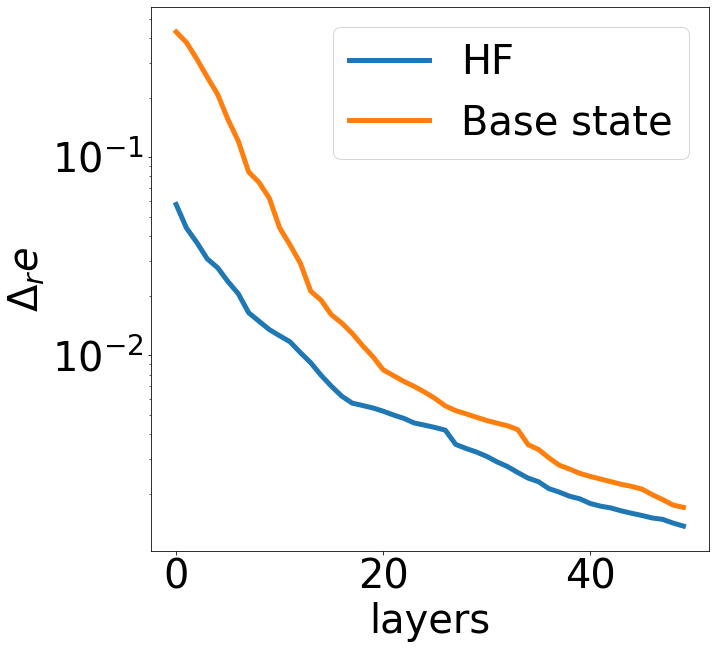

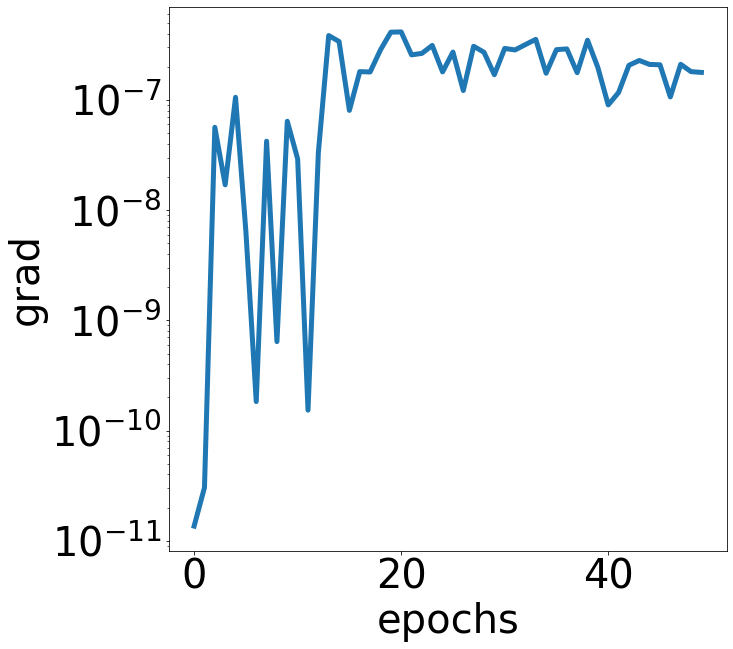

In [16]:
plt.figure(figsize=(10,10))
plt.plot(rel_error_hf,linewidth=5,label='HF')
plt.plot(rel_error_base, linewidth=5, label='Base state')
plt.xlabel('layers',fontsize=40)
plt.legend(fontsize=40)
plt.semilogy()
plt.ylabel(r'$\Delta_r e$',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(grad_history,linewidth=5)
plt.xlabel('epochs',fontsize=40)
plt.semilogy()
plt.ylabel(r'grad',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.show()

## Test Hartree Fock for different magnitude of the interaction U

In [4]:
from src.hartree_fock_library import HartreeFock, HartreeFockVariational
from src.hamiltonian_utils import (
    get_twobody_nuclearshell_model,
    FermiHubbardHamiltonian,
    SingleParticleState,
)
import numpy as np
import torch
from typing import Dict, List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
import matplotlib.pyplot as plt

In [23]:
egss=[]
e_hf=[]

t_range=tqdm(np.arange(8))
v_ext = np.random.uniform(size=size_a)

for u in t_range:

    size_a = 6
    size_b = 6
    FHHamiltonian = FermiHubbardHamiltonian(
        size_a=size_a, size_b=size_a, nparticles_a=2, nparticles_b=2
    )

    t = 1.0
    

    # define the local onsite potential
    twobody_matrix: Dict = {}
    for i in range(size_a):
        twobody_matrix[(i, i + size_a, i + size_a, i)] = u
        twobody_matrix[(i, i + size_a, i, i + size_a)] = -u
        twobody_matrix[(i + size_a, i, i + size_a, i)] = -u
        twobody_matrix[(i + size_a, i, i, i + size_a)] = u

    kinetic_term: Dict = {}
    adj_matrix = np.zeros((size_a + size_b, size_a + size_b))
    for i in range(size_a):
        kinetic_term[(i, (i + 1) % size_a)] = t
        kinetic_term[(size_a + i, size_a + (i + 1) % size_a)] = t
        adj_matrix[i, (i + 1) % size_a] = t
        adj_matrix[(i + 1) % size_a, i] = t
        adj_matrix[i, i] = -2 * t
        adj_matrix[i + size_a, i + size_a] = -2 * t
        adj_matrix[i + size_a, size_a + (i + 1) % size_a] = t
        adj_matrix[size_a + (i + 1) % size_a, size_a + i] = t

    print(adj_matrix - adj_matrix.T)
    # %%

    FHHamiltonian.get_external_potential(external_potential=np.append(v_ext, v_ext))
    FHHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
    FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    FHHamiltonian.get_hamiltonian()

    # print(FHHamiltonian.hamiltonian)
    print(FHHamiltonian.hamiltonian)
    # print(FHHamiltonian.twobody_operator)
    # print(FHHamiltonian.kinetic_operator+FHHamiltonian.twobody_operator-FHHamiltonian.hamiltonian)
    egs, psi0 = FHHamiltonian.get_spectrum(n_states=1)

    print(egs)
    egss.append(egs)

    # %% Hartree fock initialization

    HFclass = HartreeFock(size=size_a, nspecies=2)

    HFclass.get_hamiltonian(
        twobody_interaction=twobody_matrix,
        kinetic_term=adj_matrix,
        external_potential=np.append(v_ext, v_ext),
    )

    de, history_herm, ortho_history = HFclass.selfconsistent_computation(eta=1, epochs=50)

    psi_hf = HFclass.create_hf_psi(FHHamiltonian.basis, nparticles=4)
    print(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

    e_hf.append(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

  0%|          | 0/8 [00:00<?, ?it/s]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	1.5701825978640471
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	1.6313223094114457
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	1.2927693703520005
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	1.1914746452050533
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	1.0
  (221, 221)	1.62

 12%|█▎        | 1/8 [00:00<00:02,  2.98it/s]

-4.767387172958671
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-0.4298174021359529
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	0.6313223094114457
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	0.29276937035200046
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	0.1914746452050533
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	

 25%|██▌       | 2/8 [00:00<00:01,  3.02it/s]

-5.5410522137753775
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-2.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-0.36867769058855426
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-0.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-0.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 22

 38%|███▊      | 3/8 [00:00<00:01,  3.12it/s]

-6.314717254592087
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-4.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-1.3686776905885543
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-1.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-1.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)

 50%|█████     | 4/8 [00:01<00:01,  3.19it/s]

-7.088382295408795
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-6.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-2.3686776905885543
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-2.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-2.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)

 62%|██████▎   | 5/8 [00:01<00:00,  3.10it/s]

-7.862047336225506
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-8.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-3.3686776905885543
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-3.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-3.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)

 75%|███████▌  | 6/8 [00:01<00:00,  3.14it/s]

-8.635712377042212
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-10.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-4.368677690588554
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-4.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-4.808525354794947
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	

 88%|████████▊ | 7/8 [00:02<00:00,  2.99it/s]

-9.409377417858922
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-12.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-5.368677690588554
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-5.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-5.808525354794947
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

-10.18304245867563


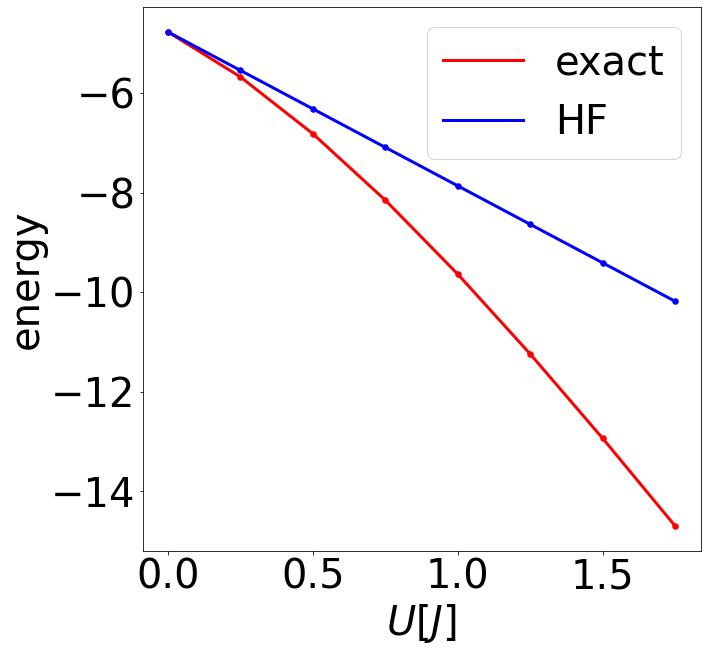

In [26]:
u=np.arange(8)/4
plt.figure(figsize=(10,10))
plt.plot(u,egss,color='red',linewidth=3,label='exact')
plt.scatter(u, egss, color="red", s=30)

plt.plot(u, e_hf, color="blue", linewidth=3,label='HF')
plt.scatter(u, e_hf, color="blue", s=30)
plt.tick_params(which='major',labelsize=40)
plt.xlabel(r'$U [J]$',fontsize=40)
plt.ylabel("energy", fontsize=40)
plt.legend(fontsize=40)
plt.show()

# Quantum Chemistry with Qiskit

In [3]:
from math import pi

import numpy as np
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel



ImportError: cannot import name 'Aer' from 'qiskit' (/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/qiskit/__init__.py)